<a href="https://colab.research.google.com/github/thedstrat/Machine-Learning-Python-Projects/blob/master/ETH_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cryptocurrency Price Correlations

---



### 1. Gather Data

In [0]:
#Downgrade dependencies (Cryptory currently won't work without these specific dependency versions)
! pip install pandas>=0.23.0
! pip install numpy>=1.14.0
! pip install pytrends>=4.4.0
! pip install beautifulsoup4>=4.0.0

#Install Cryptory
! pip install cryptory==0.1.1

#Install Sklearn
!pip install scikit-learn

#Install Keras
! pip install Keras

In [0]:
from cryptory import Cryptory
import pandas as pd
import numpy as np
import io
from math import sqrt
from google.colab import files

In [0]:
#Create function to auto-create this CSV??

#Specify my_cryptory to pull data from 2018 til now
my_cryptory = Cryptory(from_date = '2018-01-01')

In [0]:
#get historical btc and eth daily closing prices from cmc
crypto_data0 = my_cryptory.extract_coinmarketcap('bitcoin').iloc[:, 0] #get dates
crypto_data1 = my_cryptory.extract_coinmarketcap('bitcoin').iloc[:, 3] #get btc price
crypto_data2 = my_cryptory.extract_coinmarketcap('ethereum').iloc[:, 3] #get eth price

In [0]:
#get historical btc and eth daily tx fees
crypto_data3 = my_cryptory.extract_bitinfocharts("btc", metric='transactionfees')
crypto_data4 = my_cryptory.extract_bitinfocharts("eth", metric='transactionfees').iloc[:,1]

In [0]:
#find reddit data (reverse row order for each)

#This feature of cryptory appears to be broken
#crypto_data5 = my_cryptory.extract_reddit_metrics(subreddit='ethtrader', metric = 'subscriber-growth-perc').iloc[::-1]

In [0]:
#Extract ETH daily volumes and ETH amount sent in USD
crypto_data5 = my_cryptory.extract_bitinfocharts("eth", metric='transactions')
crypto_data6 = my_cryptory.extract_bitinfocharts("eth", metric='sentinusd').iloc[:,1]


In [0]:
#get google trends data
crypto_data9 = my_cryptory.get_google_trends(kw_list = ['ethereum'])
crypto_data10 = my_cryptory.get_google_trends(kw_list = ['cryptocurrency'])
crypto_data10 = crypto_data10.iloc[:,1] #delete date column

In [0]:
#get Dow industrial average (reverse rows necessary?)
crypto_data11 = my_cryptory.get_stock_prices(market="%5EDJI")
crypto_data11 = crypto_data11.iloc[:, 3] #select column 3 and all rows

In [0]:
#Concatenate into one df
crypto_data = pd.concat([crypto_data0, crypto_data1, crypto_data2, crypto_data3, crypto_data4, crypto_data5, crypto_data6, crypto_data9, crypto_data10, crypto_data11], axis = 1) #concatenate
crypto_data.columns = ['date1', 'btc_close', 'eth_close', 'date2', 'btc_avgtxcost', 'eth_avgtxcost', 'date3', 'eth_txs', 'eth_sentinusd','date4', 'eth_Gsearch', 'crypto_Gsearch', 'Dow Average']

print(crypto_data)

In [0]:
#Reverse all rows (order first date to last)
crypto_data = crypto_data.iloc[::-1]

#Shift Google Search columns
#crypto_data[date4] = crypto_data['date4'].shift(1)
#crypto_data[eth_Gsearch] = crypto_data['eth_Gsearch'].shift(1)
#crypto_data[crypto_Gsearch] = crypto_data['crypto_Gsearch'].shift(1)

#Or delete first row(s)
#crypto_data = crypto_data.iloc[1:] #delete first two rows


In [0]:
# Data Cleaning

#Convert date1 column entries from objects to floats
crypto_data['date1'] = crypto_data['date1'].convert_objects(convert_numeric=True)

#Set index as the first date column
crypto_data.set_index('date1', inplace=True)

# Set NA values to 0
crypto_data.fillna(0, inplace=True)

#Drop all additional date columns
crypto_data.drop(['date2', 'date3', 'date4'], axis = 1, inplace = True)

#print(df.head())
print(crypto_data.dtypes)

In [0]:
# Convert df to json (only for my webapp)
crypto_data = crypto_data.to_json(orient='split')

print(crypto_data)

### 2. Download and Upload CSV

In [0]:
#Download file
crypto_data.to_csv('trendsdf.csv')
files.download('trendsdf.csv')

In [0]:
#Upload CSV as dataframe to Colab
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['trendsdf.csv']), header=0, index_col=0)

### 3. Create a Dataset of 'Window' values

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [0]:
#Citation: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
# Multi-Variate Forecasting

# Save df as a numpy array
values = df.values

# I don't think label encoding is necessary for any of these features bc/ they're all continuous variables. Right?
# encoder = preprocessing.LabelEncoder()
# values[:, 4] = encoder.fit_transform(values[:, 4])

# Convert all values to float
values = values.astype('float32')

print(values[:5])

In [0]:
# Normalize all features (btw/ 0 and 1).
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(scaled[:5])

In [0]:
# Call function to return new ndarray. Shift values down by 1 for cols 1-9 and don't shift for cols 10-19 to make future 'windows' of 1 day. I think?
reframed = series_to_supervised(scaled, 1, 1)

In [0]:
# Drop columns we don't want as features, I think? (eth price which is col 10 i believe)
reframed.drop(reframed.columns[[9, 11, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)
print(reframed[:-1])

###Train, Test, Split

In [0]:
# Split rows into train set (400 days) and test set (101 days)
values = reframed.values
n_train_days = 400 
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# Split columns into label and feature sets
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_y) #double check this prints out eth prices

'''
#Create training and testing sets. Double check this is correct..
features = reframed.values[[0, 1, 2, 3, 4, 5, 6, 7, 8]]
label = reframed.values[9]
train_X, test_X, train_y, test_y = train_test_split(features, label, test_size=0.33, random_state=42)
'''

In [0]:
print(train_y) #pretty sure this prints out eth prices til around 3 months ago

In [0]:
# reshape input to be 3D [samples, timesteps, features]. This is the expected format for the LSTM.
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(test_y)

###4. Fit to an LSTM

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Design LSTM with (analyze and modify this in a bit)
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [0]:
# Fit model
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [0]:
from matplotlib import pyplot

# Plot losses
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

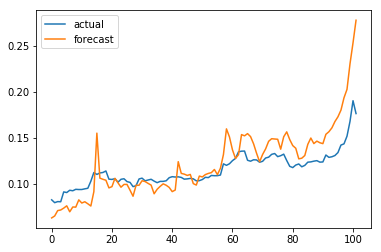

In [0]:
# make a prediction for all x values (this is just x test). This should go in the modeling function.
yhat = model.predict(test_X)

# Plot modeled values and actual values
pyplot.plot(test_y, label='actual')
pyplot.plot(yhat, label='forecast')
pyplot.legend()
pyplot.show()

###5. Evaluate (incomplete)

In [0]:
# Make a prediction for y (bitcoin is currently y i believe)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) #Why reshape test_X?

In [0]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 8:]), axis=1) #Add y forecast to the right of test_X in inv_yhat. Not sure combining the correct columns here.
inv_yhat = scaler.inverse_transform(inv_yhat) #scale this new set back to non-normalized form
inv_yhat = inv_yhat[:,0] #Select the first column

In [0]:
print(test_X)

In [0]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1)) #?
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1) #add forecast to test_y
inv_y = scaler.inverse_transform(inv_y) #remove normalization
inv_y = inv_y[:,0]

In [0]:
#print(inv_y)

# Plot forecast vs actual
pyplot.plot(inv_y, label='actual')
pyplot.plot(inv_yhat, label='forecast')
pyplot.legend()
pyplot.show()

In [0]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1910.303
